In [1]:
# Packages for data manipulation
import numpy as np
import pandas as pd
import json

In [2]:
# Packages for dataviz
import plotly.express as px
import plotly.tools as tls
import plotly.graph_objects as go
import cufflinks as cf
import matplotlib.pyplot as plt

In [3]:
# offline configuration of cufflinks
cf.go_offline()

In [4]:
pd.set_option('display.max_columns', 110)

In [5]:
# Load the data
data = pd.read_csv('../data/clean.csv')

with open('../data/meta_data.json') as json_file:
    meta = json.load(json_file)

In [6]:
meta['y']
data.head()

,review_scores_rating,accommodates,guests_included,availability_365,number_of_reviews_ltm,minimum_nights_avg_ntm,maximum_nights_avg_ntm,bathrooms,bedrooms,beds,host_listings_count,price,extra_people,security_deposit,cleaning_fee,host_response_rate,amenities,host_verifications,maximum_nights,minimum_nights,city,host_response_time,property_type,room_type,bed_type,cancellation_policy,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,host_is_superhost,host_has_profile_pic,host_identity_verified,host_is_close,latitude,longitude,neighbourhood_cleansed,first_review,last_review,host_since,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,host_about
0,97.0,3,2,85,52,1,30,1.0,1.0,2.0,1.0,170,25,100.0,100.0,100.0,32,5,30,1,San Francisco,within a day,Apartment,Entire home/apt,Real Bed,moderate,True,False,False,False,True,True,True,True,37.76931,-122.43386,Western Addition,3734.0,22.0,4089.0,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,*Quiet cul de sac in friendly neighborhood *St...,Due to the fact that we have children and a do...,*Public Transportation is 1/2 block away. *Ce...,*Full access to patio and backyard (shared wit...,A family of 4 lives upstairs with their dog. N...,* No Pets - even visiting guests for a short t...,We are a family with 2 boys born in 2009 and 2...
1,94.0,2,2,62,36,1,5,1.0,1.0,1.0,2.0,99,20,0.0,10.0,100.0,30,5,5,1,San Francisco,within an hour,House,Private room,Real Bed,strict_14_with_grace_period,True,False,False,False,True,True,True,True,37.75402,-122.45805,Inner Sunset,3741.0,13.0,3959.0,Charming room for two,Your own private room plus access to a shared ...,This room can fit two people. Nobody else will...,Your own private room plus access to a shared ...,"This is a quiet, safe neighborhood on a substa...",House Rule footnotes: 1.\tI don’t allow check ...,Public transit service to my house is outstand...,"During the hours of 7:00 to 22:00, your access...","I live at the house in my own bedroom, and I w...",Airbnb has no default house rules that hosts c...,I am a retired software developer now raising ...
2,98.0,5,2,0,0,30,60,1.0,2.0,3.0,2.0,235,0,NaN,100.0,80.0,17,5,60,30,San Francisco,within a day,Apartment,Entire home/apt,Real Bed,strict_14_with_grace_period,True,False,False,False,False,True,True,True,37.74511,-122.42102,Bernal Heights,3815.0,798.0,3875.0,Creative Sanctuary,NaN,We live in a large Victorian house on a quiet ...,We live in a large Victorian house on a quiet ...,I love how our neighborhood feels quiet but is...,All the furniture in the house was handmade so...,The train is two blocks away and you can stop ...,"Our deck, garden, gourmet kitchen and extensiv...",NaN,"Please respect the house, the art work, the fu...",Philip: English transplant to the Bay Area and...
3,86.0,2,1,365,1,32,60,4.0,1.0,1.0,10.0,65,12,200.0,50.0,86.0,18,5,60,32,San Francisco,within an hour,Apartment,Private room,Real Bed,strict_14_with_grace_period,True,False,False,False,True,True,True,True,37.76669,-122.45250,Haight Ashbury,3695.0,33.0,3768.0,A Friendly Room - UCSF/USF - San Francisco,Nice and good public transportation. 7 minute...,"Settle down, S.F. resident, student, hospital,...",Nice and good public transportation. 7 minute...,"Shopping old town, restaurants, McDonald, Whol...",Wi-Fi signal in common areas. Large eat in k...,N Juda Muni and bus stop. Street parking.,NaN,NaN,"No party, No smoking, not for any kinds of smo...",7 minutes walk to UCSF hospital & school campu...
4,93.0,2,1,365,0,32,90,4.0,1.0,1.0,10.0,65,12,200.0,50.0,86.0,16,5,90,32,San Francisco,within an hour,Apartment,Private room,Real Bed,strict_14_with_grace_period,True,False,False,False,True,True,True,True,37.76487,-122.45183,Haight Ashbury,1861.0,396.0,3768.0,Friendly Room Apt. Style -UCSF/USF - San Franc

# 1. Modification des variables

## 1.1 Discretisation de Y

Le prof veut qu'on fasse de la clssification et pas de la regression, il faut choisir les categories de la variable Y

In [7]:
px.histogram(data, x = meta['y'], marginal="box").show()

On peut couper selon le 1er quartil et la moyenne. Cela permet de distribuer les valeurs de manière à peu près homogène. 

In [8]:
y_cat = pd.cut(data[meta['y']], bins=[0, 95, 98, 100], labels=['bad', 'good', 'excellent'])

In [9]:
print(y_cat.value_counts())

excellent    2625
bad          1979
good         1848
Name: review_scores_rating, dtype: int64


In [10]:
data[meta['y']] = y_cat

## 1.2 Traitement des donnees geospatiales

Pour les donnees geospatiales, on propose de diviser les quartiers (neighbourhoods_cleansed) en trois categories (good, neutral, bad). On preconise que le l'indicateur qui aura le plus grand impact sur la perception de la qualité des appartements, directement et indirectement, sera le taux de criminalite dans le quartier. Donnees tirees de https://www.areavibes.com/san+francisco-ca/crime/

Selon le score de criminalite de chaque quartier, attribue un score 0, 1, 2.

F a D- : 2
D a B- : 1
B a A+ : 0

On ajoute une colonne 'crime' aux données, qui attribue ce score 0/1/2.

In [11]:
#Ajout d'une colonne 'crime'

neighbourhood_crime=[['Bayview', 'Bernal Heights', 'Castro/Upper Market', 'Chinatown', 'Diamond Heights', 'Downtown/Civic Center','Haight Ashbury','Lakeshore', 'Marina', 'Mission', 'Nob Hill', 'Outer Mission', 'Potrero Hill', 'Russian Hill', 'South of Market', 'Visitacion Valley', 'Western Addition'],
                     ['Excelsior', 'Financial District', 'Golden Gate Park', 'Glen Park', 'Inner Richmond', 'North Beach', 'Pacific Heights', 'Parkside', 'Presidio Heights', 'Seacliff', 'Twin Peaks', 'West of Twin Peaks'],
                     ['Crocker Amazon', 'Inner Sunset', 'Noe Valley', 'Ocean View', 'Outer Richmond', 'Outer Sunset', 'Treasure Island/YBI']]

data['crime'] = float('nan')
crime_color = []

In [12]:
#Remplissage de la colonne 'crime'

for i in range(len(data)):
    
    if data['neighbourhood_cleansed'][i] in neighbourhood_crime[0]:
        data['crime'][i] = 2
        crime_color.append('maroon')
    
    elif data['neighbourhood_cleansed'][i] in neighbourhood_crime[1]:
        data['crime'][i] = 1
        crime_color.append('darkorange')
    
    elif data['neighbourhood_cleansed'][i] in neighbourhood_crime[2]:
        data['crime'][i] = 0
        crime_color.append('orangered')
    
    else:
        #print('review neighbourhood_crime for missing neighbourhoods')
        crime_color.append('grey')

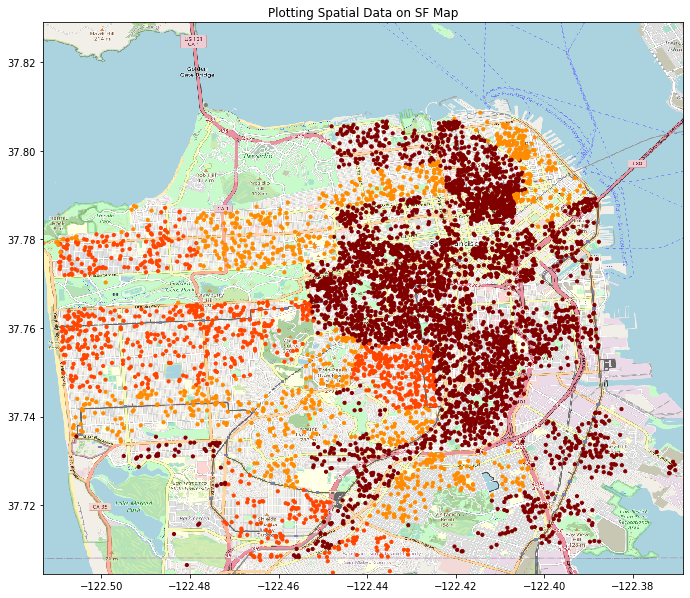

In [13]:
# Visualisation des donnees sur une carte :


#Box = (data.longitude.min(),   data.longitude.max(),      
#        data.latitude.min(), data.latitude.max())
    
Box = (-122.5132, -122.3686,      
       37.7045, 37.8290)

carte = plt.imread("../data/map.png")

fig, ax = plt.subplots(figsize = (11.48,12.48))
ax.scatter(data.longitude, data.latitude, zorder=1, alpha= 1, c=crime_color, s=10)
#ax.scatter(data.longitude, data.latitude, zorder=1, alpha= 1, c='fuchsia', s=10)
ax.set_title('Plotting Spatial Data on SF Map')
ax.set_xlim(Box[0],Box[1])
ax.set_ylim(Box[2],Box[3])
ax.imshow(carte, zorder=0, extent = Box, aspect= 'equal')

#fig.savefig('testeo')

## 1.3 Traitement des variables categoriques

In [14]:
data['property_type'].value_counts()

Apartment             2334
House                 1982
Condominium            716
Guest suite            553
Boutique hotel         175
Hotel                  129
Townhouse              118
Serviced apartment      87
Loft                    82
Hostel                  80
Bed and breakfast       41
Guesthouse              38
Aparthotel              37
Other                   23
Bungalow                15
Cottage                 12
Resort                   9
Villa                    8
Castle                   4
Tiny house               3
Earth house              2
Cabin                    2
Dome house               1
In-law                   1
Name: property_type, dtype: int64

In [15]:
data['property_type'] = data['property_type'].replace(['Serviced apartment', 'Loft'], 'Apartment')

data['property_type'] = data['property_type'].replace(['Boutique hotel', 'Hostel','Aparthotel'], 'Hotel')

data['property_type'] = data['property_type'].replace(['Townhouse', 'Guesthouse', 'Villa'], 'House')

data['property_type'] = data['property_type'].replace(['Bed and breakfast'], 'Guest suite')

data['property_type'] = data['property_type'].replace(['Bungalow', 'Cottage', 'Earth house', 'Cabin', 'In-law',
                                       'Dome house', 'Resort', 'Castle', 'Tiny house'], 'Other')

Il faut verifier les categories que j'ai crée, j'ai des doutes sur certains regroupements, comme par exemple pour **Loft, Aparthotel, ...**

In [16]:
data['city'] = data['city'].replace(['San Francisco, Hayes Valley', 'Noe Valley - San Francisco', 
                                     'San Francisco ', 'Brisbane'], 'San Francisco')

In [17]:
print(data['crime'].isna().sum())
data['crime'].value_counts()

1


2.0    4325
1.0    1099
0.0    1027
Name: crime, dtype: int64

In [18]:
#data["name"] + " " + data["summary"]

for var in meta["text"]:
    data[var] = data[var].replace(np.nan, "", regex=True)

In [19]:
data["name"] = data["name"] + " " + data["summary"] + " " + data["space"] + " " + data["description"]

data["neighborhood_overview"] = data["neighborhood_overview"] + " " + data["notes"] + " " + data["interaction"] + " " + data["house_rules"] + " " + data["host_about"]

data["transit"] = data["transit"] + " " + data["access"]

In [20]:
data = data.drop(['summary', 'space', 'description', 'notes', 'interaction', 'house_rules', 'host_about', 'access'], axis=1)

data = data.rename(columns={"name": "housing_description", "neighborhood_overview": "context_description"})

In [21]:
data.head()

,review_scores_rating,accommodates,guests_included,availability_365,number_of_reviews_ltm,minimum_nights_avg_ntm,maximum_nights_avg_ntm,bathrooms,bedrooms,beds,host_listings_count,price,extra_people,security_deposit,cleaning_fee,host_response_rate,amenities,host_verifications,maximum_nights,minimum_nights,city,host_response_time,property_type,room_type,bed_type,cancellation_policy,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,host_is_superhost,host_has_profile_pic,host_identity_verified,host_is_close,latitude,longitude,neighbourhood_cleansed,first_review,last_review,host_since,housing_description,context_description,transit,crime
0,good,3,2,85,52,1,30,1.0,1.0,2.0,1.0,170,25,100.0,100.0,100.0,32,5,30,1,San Francisco,within a day,Apartment,Entire home/apt,Real Bed,moderate,True,False,False,False,True,True,True,True,37.76931,-122.43386,Western Addition,3734.0,22.0,4089.0,"Bright, Modern Garden Unit - 1BR/1B New update...",*Quiet cul de sac in friendly neighborhood *St...,*Public Transportation is 1/2 block away. *Ce...,2.0
1,bad,2,2,62,36,1,5,1.0,1.0,1.0,2.0,99,20,0.0,10.0,100.0,30,5,5,1,San Francisco,within an hour,House,Private room,Real Bed,strict_14_with_grace_period,True,False,False,False,True,True,True,True,37.75402,-122.45805,Inner Sunset,3741.0,13.0,3959.0,Charming room for two Your own private room pl...,"This is a quiet, safe neighborhood on a substa...",Public transit service to my house is outstand...,0.0
2,good,5,2,0,0,30,60,1.0,2.0,3.0,2.0,235,0,NaN,100.0,80.0,17,5,60,30,San Francisco,within a day,Apartment,Entire home/apt,Real Bed,strict_14_with_grace_period,True,False,False,False,False,True,True,True,37.74511,-122.42102,Bernal Heights,3815.0,798.0,3875.0,Creative Sanctuary We live in a large Victori...,I love how our neighborhood feels quiet but is...,The train is two blocks away and you can stop ...,2.0
3,bad,2,1,365,1,32,60,4.0,1.0,1.0,10.0,65,12,200.0,50.0,86.0,18,5,60,32,San Francisco,within an hour,Apartment,Private room,Real Bed,strict_14_with_grace_period,True,False,False,False,True,True,True,True,37.76669,-122.45250,Haight Ashbury,3695.0,33.0,3768.0,A Friendly Room - UCSF/USF - San Francisco Nic...,"Shopping old town, restaurants, McDonald, Whol...",N Juda Muni and bus stop. Street parking.,2.0
4,bad,2,1,365,0,32,90,4.0,1.0,1.0,10.0,65,12,200.0,50.0,86.0,16,5,90,32,San Francisco,within an hour,Apartment,Private room,Real Bed,strict_14_with_grace_period,True,False,False,False,True,True,True,True,37.76487,-122.45183,Haight Ashbury,1861.0,396.0,3768.0,Friendly Room Apt. Style -UCSF/USF - San Franc...,Wi-Fi signal in common areas. Large eat in ...,"N Juda Muni, Bus and UCSF Shuttle. small shopp...",2.0


# 2. Separation entrainement/validation

In [100]:
from sklearn.model_selection import train_test_split

# separate target from predictors
y = data[meta['y']]
X = data.drop(columns = meta['y'])

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [23]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x = ["excellent", "bad", "good"],
    y = y_train.value_counts(),
    name = 'train',
    #marker_color = 'indianred',
))

fig.add_trace(go.Bar(
    x = ["excellent", "bad", "good"],
    y = y_valid.value_counts(),
    name = 'validation',
    #marker_color = 'lightsalmon',
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
#fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

In [24]:
print(y_train.value_counts())
print()
print(y_valid.value_counts())

excellent    2103
bad          1573
good         1485
Name: review_scores_rating, dtype: int64

excellent    522
bad          406
good         363
Name: review_scores_rating, dtype: int64


On constate que les classes sont à peu pres bien reparties dans les ensembles "train" et "validation"

## 3.2 Données textuelles

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from nltk.stem import LancasterStemmer
import nltk
nltk.download('punkt')
import re
import string

[nltk_data] Downloading package punkt to C:\Users\Florent
[nltk_data]     Glauda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
stemmer = LancasterStemmer()

def tokenize(text):
        return [stemmer.stem(re.sub(r'\d+', '', word).translate(str.maketrans('', '', string.punctuation))) for word in nltk.word_tokenize(text) if len(word) > 1]


In [27]:
var_text = ["housing_description", "context_description", "transit"]

In [28]:
for var in var_text:
    
    # On construit la matrice terme-document avec la ponderation TF-IDF. On note le vocabulaire obtenu
    vectorizer = TfidfVectorizer(lowercase = True,
                             stop_words = 'english',
                             min_df = 200,
                             tokenizer = tokenize
                            )

    td = vectorizer.fit_transform(X_train[var])
    voc = vectorizer.get_feature_names()
    
    print(voc)
    
    # On crée des clusters sur la matrice terme-document. On remplace chaque document par son numero de cluster 
    kmeans = KMeans(n_clusters=5, init = 'random', random_state=0).fit( preprocessing.scale(td.todense()) )
    X_train[var] = kmeans.predict( preprocessing.scale(td.todense()) )
    
    # Pour l'ensemble de validation, on crée ensuite la matrice terme-document avec le vocabulaire precedent
    new_vectorizer = TfidfVectorizer(lowercase = True,
                             tokenizer = tokenize,
                             vocabulary = voc)

    # On regarde ensuite dans quel cluster tombe chaque document
    new_td = new_vectorizer.fit_transform(X_valid[var])
    X_valid[var] = kmeans.predict( preprocessing.scale(new_td.todense()) )
    
    print( var + " : done" )

C:\Users\Florent Glauda\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'aft', 'afterward', 'al', 'alon', 'alway', 'anoth', 'anyon', 'anyth', 'anywh', 'ar', 'becam', 'becaus', 'becom', 'bef', 'besid', 'bil', 'cal', 'describ', 'don', 'dur', 'eith', 'elev', 'els', 'elsewh', 'ev', 'everyon', 'everyth', 'everywh', 'exceiv', 'fil', 'fir', 'fiv', 'form', 'ful', 'furth', 'giv', 'hav', 'hent', 'hereaft', 'howev', 'hundr', 'indee', 'int', 'lat', 'mad', 'meanwhil', 'mil', 'min', 'mor', 'moreov', 'mov', 'nam', 'neith', 'nev', 'nin', 'non', 'noon', 'noth', 'nowh', 'oft', 'ont', 'oth', 'otherw', 'ourselv', 'ov', 'perhap', 'pleas', 'rath', 'sam', 'sery', 'sev', 'sid', 'sint', 'som', 'someon', 'someth', 'sometim', 'somewh', 'stil', 'tak', 'themselv', 'thent', 'ther', 'thereaft', 'theref', 'thes', 'thi', 'thos', 'thu', 'togeth', 'twelv', 'und', 'wel', 'wer'

['', 'access', 'accommod', 'addit', 'adv', 'aft', 'air', 'airbnb', 'airport', 'al', 'allow', 'alway', 'amaz', 'anoth', 'anyth', 'apart', 'apply', 'apt', 'ar', 'area', 'art', 'ask', 'attract', 'av', 'avail', 'away', 'backyard', 'bar', 'bart', 'bas', 'bath', 'bathroom', 'bay', 'bbq', 'beach', 'beauty', 'becaus', 'bed', 'bedroom', 'bef', 'bern', 'best', 'big', 'block', 'board', 'book', 'bout', 'br', 'brand', 'breakfast', 'bridg', 'bright', 'build', 'built', 'bus', 'busy', 'cabl', 'caf', 'cal', 'car', 'castro', 'ceil', 'cent', 'chair', 'charm', 'check', 'checkin', 'chinatown', 'city', 'class', 'cle', 'clos', 'closet', 'coff', 'col', 'com', 'comfort', 'comfy', 'common', 'commun', 'complet', 'comply', 'condo', 'connect', 'conveny', 'cook', 'corn', 'couch', 'count', 'coupl', 'cozy', 'cre', 'day', 'dec', 'deck', 'design', 'desk', 'din', 'direct', 'dishwash', 'dist', 'district', 'dog', 'dol', 'door', 'doubl', 'downstair', 'downtown', 'dress', 'driv', 'dry', 'dur', 'easy', 'eat', 'edward', 'elec

C:\Users\Florent Glauda\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'aft', 'afterward', 'al', 'alon', 'alway', 'anoth', 'anyon', 'anyth', 'anywh', 'ar', 'becam', 'becaus', 'becom', 'bef', 'besid', 'bil', 'cal', 'describ', 'don', 'dur', 'eith', 'elev', 'els', 'elsewh', 'ev', 'everyon', 'everyth', 'everywh', 'exceiv', 'fil', 'fir', 'fiv', 'form', 'ful', 'furth', 'giv', 'hav', 'hent', 'hereaft', 'howev', 'hundr', 'indee', 'int', 'lat', 'mad', 'meanwhil', 'mil', 'min', 'mor', 'moreov', 'mov', 'nam', 'neith', 'nev', 'nin', 'non', 'noon', 'noth', 'nowh', 'oft', 'ont', 'oth', 'otherw', 'ourselv', 'ov', 'perhap', 'pleas', 'rath', 'sam', 'sery', 'sev', 'sid', 'sint', 'som', 'someon', 'someth', 'sometim', 'somewh', 'stil', 'tak', 'themselv', 'thent', 'ther', 'thereaft', 'theref', 'thes', 'thi', 'thos', 'thu', 'togeth', 'twelv', 'und', 'wel', 'wer'

['', 'abl', 'abov', 'absolv', 'access', 'accommod', 'act', 'addit', 'adv', 'aft', 'ag', 'airbnb', 'al', 'allow', 'alway', 'amaz', 'anoth', 'answ', 'anyon', 'anyth', 'anytim', 'anywh', 'apart', 'apply', 'apprecy', 'ar', 'area', 'art', 'ask', 'assist', 'attract', 'avail', 'aw', 'away', 'backyard', 'bakery', 'bar', 'bart', 'bas', 'bathroom', 'bay', 'beach', 'beauty', 'becaus', 'bed', 'bedroom', 'bef', 'bern', 'best', 'big', 'bik', 'bit', 'block', 'book', 'bout', 'bridg', 'bring', 'build', 'bus', 'busy', 'ca', 'cabl', 'caf', 'cal', 'californ', 'cancel', 'car', 'cas', 'castro', 'cat', 'cent', 'chang', 'charg', 'charm', 'check', 'checkin', 'checkout', 'childr', 'city', 'class', 'cle', 'clos', 'cod', 'coff', 'col', 'com', 'comfort', 'common', 'commun', 'company', 'complet', 'condit', 'connect', 'consid', 'contact', 'conveny', 'cook', 'corn', 'cost', 'country', 'coupl', 'cours', 'court', 'cre', 'cult', 'cur', 'd', 'dai', 'day', 'deck', 'deposit', 'design', 'desk', 'diff', 'din', 'direct', 'dis

C:\Users\Florent Glauda\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'aft', 'afterward', 'al', 'alon', 'alway', 'anoth', 'anyon', 'anyth', 'anywh', 'ar', 'becam', 'becaus', 'becom', 'bef', 'besid', 'bil', 'cal', 'describ', 'don', 'dur', 'eith', 'elev', 'els', 'elsewh', 'ev', 'everyon', 'everyth', 'everywh', 'exceiv', 'fil', 'fir', 'fiv', 'form', 'ful', 'furth', 'giv', 'hav', 'hent', 'hereaft', 'howev', 'hundr', 'indee', 'int', 'lat', 'mad', 'meanwhil', 'mil', 'min', 'mor', 'moreov', 'mov', 'nam', 'neith', 'nev', 'nin', 'non', 'noon', 'noth', 'nowh', 'oft', 'ont', 'oth', 'otherw', 'ourselv', 'ov', 'perhap', 'pleas', 'rath', 'sam', 'sery', 'sev', 'sid', 'sint', 'som', 'someon', 'someth', 'sometim', 'somewh', 'stil', 'tak', 'themselv', 'thent', 'ther', 'thereaft', 'theref', 'thes', 'thi', 'thos', 'thu', 'togeth', 'twelv', 'und', 'wel', 'wer'

['', 'access', 'addit', 'airbnb', 'airport', 'al', 'anywh', 'ap', 'apart', 'ar', 'area', 'avail', 'away', 'backyard', 'bart', 'bathroom', 'bay', 'beach', 'bedroom', 'best', 'bik', 'block', 'bridg', 'build', 'bus', 'cabl', 'caltrain', 'car', 'castro', 'cent', 'check', 'city', 'cle', 'clos', 'cod', 'coff', 'com', 'common', 'connect', 'conveny', 'corn', 'day', 'deck', 'din', 'direct', 'dist', 'district', 'door', 'downtown', 'driv', 'dry', 'dur', 'east', 'easy', 'embarcadero', 'enjoy', 'ent', 'entir', 'ev', 'fin', 'fisherm', 'flat', 'flo', 'francisco', 'fre', 'freeway', 'ful', 'gar', 'gard', 'gat', 'gold', 'gre', 'guest', 'hav', 'hid', 'hil', 'hom', 'hour', 'hous', 'includ', 'just', 'key', 'kitch', 'laundry', 'light', 'lik', 'limit', 'lin', 'liv', 'll', 'loc', 'lock', 'lot', 'lyft', 'main', 'maj', 'mak', 'market', 'mil', 'min', 'minut', 'miss', 'mor', 'mun', 'near', 'nearby', 'nee', 'neighb', 'nt', 'oc', 'op', 'opt', 'oth', 'outsid', 'park', 'patio', 'plac', 'pleas', 'plenty', 'pm', 'priv'

# 3. Preprocessing et entrainement du modele

In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


### Trie à faire dans les imports

In [30]:
####### Etudier les SimpleImputer

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy = 'most_frequent')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ordinal', OrdinalEncoder())
    #('label', LabelEncoder())
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, meta['quant'] + meta['date']),
        #('cat', categorical_transformer, meta['cat'] + meta['bool'] + ['crime'])
        ('cat', categorical_transformer, meta['cat'] + meta['bool'] + ['crime'] + var_text)
    ])

label = meta['quant'] + meta['date'] + meta['cat'] + meta['bool'] + ['crime'] + var_text
#label = meta['quant'] + meta['date'] + meta['cat'] + meta['bool'] + ['crime']

In [31]:
# Define model
model_rf = RandomForestClassifier(n_estimators=100, random_state=0)
model_tree = DecisionTreeClassifier(random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model_rf)
                         ])

clf_tree = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model_tree)
                         ])

# 4. Etude des résultats

In [32]:
# Preprocessing of training data, fit model 
clf_rf.fit(X_train, y_train)
clf_tree.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds_rf = clf_rf.predict(X_valid)
preds_tree = clf_tree.predict(X_valid)

In [33]:
import plotly.figure_factory as ff

def show_results(name, y_valid, preds):
    
    label = ["bad", "good", "excellent"]
    label_r = label.copy()
    label_r.reverse()
    
    # precision
    print("Accuracy", name, ":", metrics.accuracy_score(y_valid, preds),"\n")

    # matrice de confusion
    m = metrics.confusion_matrix(y_valid, preds, labels = label)
    #print("Confusion matrix", name, ":\n%s" % m)
    
    # heatmap
    h = []
    for elt in reversed(m):
        h.append(elt)
    
    ff.create_annotated_heatmap(
            z = h,
            x = label,
            y = label_r,
            colorscale = "oryel"
        ).show()

## 4.1 Accuracy et matrice de confusion

In [34]:
show_results("random forest", y_valid, preds_rf)

Accuracy random forest : 0.6243222308288149 



In [35]:
show_results("classification tree", y_valid, preds_tree)

Accuracy classification tree : 0.5205267234701781 



## 4.2 Importance des variables

In [36]:
# etude de l'importance des variables
imp_tree = clf_tree.steps[1][1].feature_importances_
imp_rf = clf_rf.steps[1][1].feature_importances_

In [37]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x = imp_tree,
    y = label,
    name = 'tree',
    orientation = 'h'
))

fig.add_trace(go.Bar(
    x = imp_rf,
    y = label,
    name = 'random forest',
    orientation = 'h'
))

fig.update_layout(
    #autosize = True,
    # width=500,
    height = 1000
)

fig.show()

## 4.3 Affichage de l'arbre

In [38]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

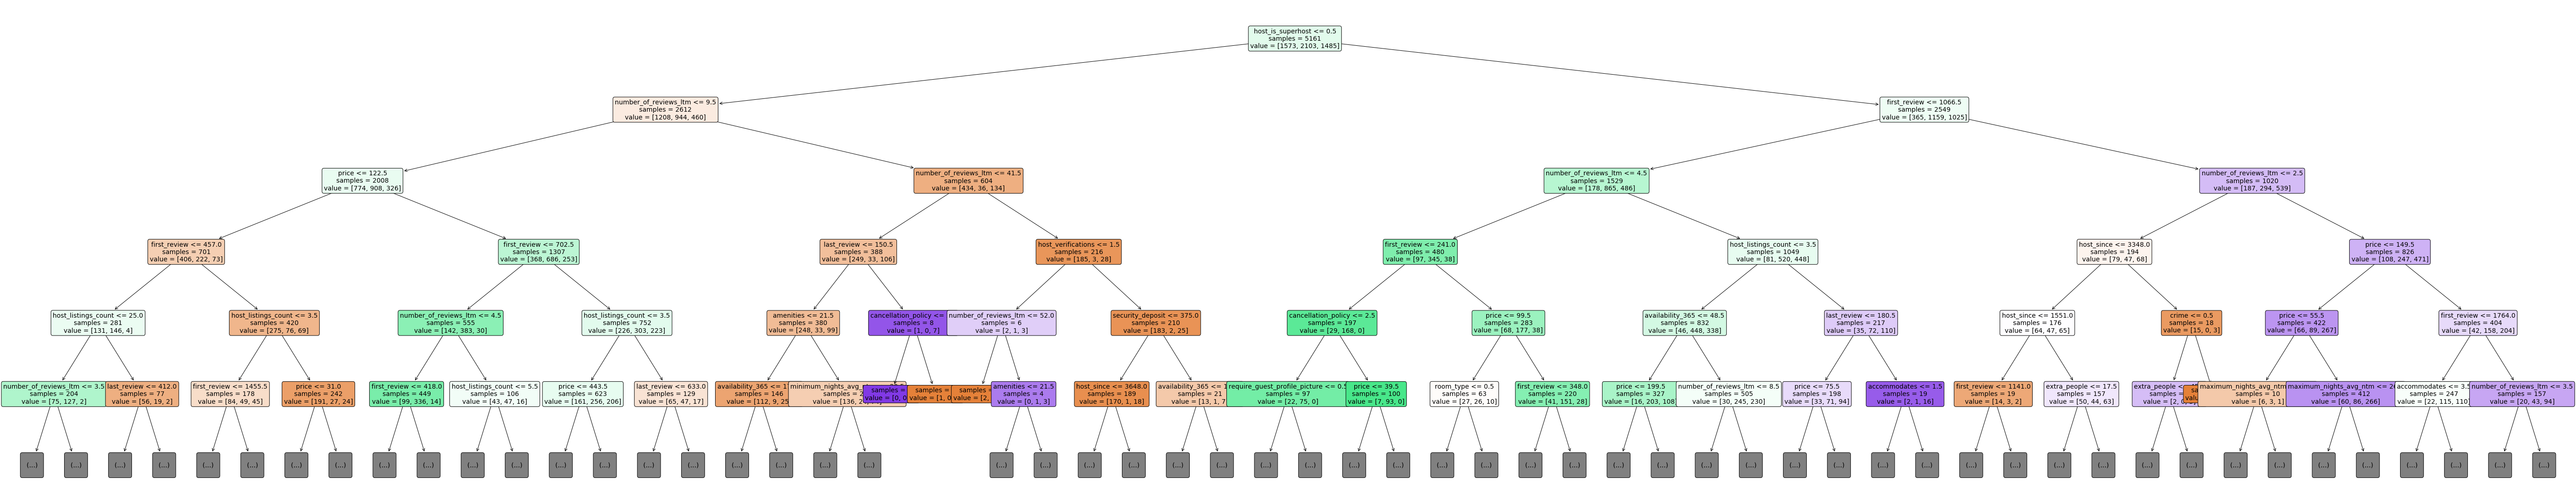

In [39]:
plt.figure(figsize=(100,20))
a = plot_tree(clf_tree[1], 
              feature_names = label, 
              filled = True, 
              rounded = True, 
              fontsize = 14,
              max_depth=5,
              impurity = False)

value : [ bad, excellent, good ]

In [40]:
y_train.value_counts()

excellent    2103
bad          1573
good         1485
Name: review_scores_rating, dtype: int64

In [41]:
data_to_print = X_train.join(y_train)

In [42]:
data_to_print.head()

,accommodates,guests_included,availability_365,number_of_reviews_ltm,minimum_nights_avg_ntm,maximum_nights_avg_ntm,bathrooms,bedrooms,beds,host_listings_count,price,extra_people,security_deposit,cleaning_fee,host_response_rate,amenities,host_verifications,maximum_nights,minimum_nights,city,host_response_time,property_type,room_type,bed_type,cancellation_policy,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,host_is_superhost,host_has_profile_pic,host_identity_verified,host_is_close,latitude,longitude,neighbourhood_cleansed,first_review,last_review,host_since,housing_description,context_description,transit,crime,review_scores_rating
5836,8,1,76,6,1,60,3.0,3.0,3.0,3.0,1300,0,NaN,NaN,93.0,53,3,60,1,San Francisco,within a few hours,Hotel,Entire home/apt,Real Bed,moderate,True,False,False,False,True,True,False,True,37.80498,-122.42373,Russian Hill,161.0,16.0,376.0,1,2,0,2.0,excellent
5909,1,1,4,4,1,180,1.5,1.0,1.0,3.0,81,0,200.0,100.0,100.0,31,3,180,1,San Francisco,within an hour,House,Private room,Real Bed,strict_14_with_grace_period,True,True,False,False,True,True,False,True,37.75120,-122.43542,Noe Valley,154.0,84.0,2621.0,4,2,4,0.0,excellent
867,2,1,347,0,30,1125,1.0,1.0,1.0,1.0,100,0,NaN,NaN,NaN,6,6,1125,30,San Francisco,NaN,Apartment,Private room,Real Bed,moderate,True,False,False,False,False,True,True,True,37.76162,-122.42394,Mission,2130.0,1686.0,2131.0,4,3,4,2.0,good
3761,2,1,69,0,2,30,1.0,1.0,1.0,2.0,110,0,100.0,30.0,100.0,18,8,30,2,San Francisco,within a day,House,Private room,Real Bed,strict_14_with_grace_period,True,False,False,False,False,True,True,False,37.72988,-122.44969,Outer Mission,737.0,721.0,3609.0,3,3,3,2.0,bad
5818,2,2,271,13,2,365,1.0,1.0,1.0,192.0,184,5,400.0,40.0,93.0,19,4,1125,2,San Francisco,within an hour,Hotel,Private room,Real Bed,strict_14_with_grace_period,True,True,False,False,False,True,False,True,37.77440,-122.42180,Downtown/Civic Center,191.0,19.0,366.0,3,1,0,2.0,bad


In [43]:
color = []

for row in data_to_print.itertuples(index=False):
    
    if row.review_scores_rating == "excellent":
        color.append('maroon')
        
    elif row.review_scores_rating == "good":
        color.append('darkorange')
        
    elif row.review_scores_rating == "bad":
        color.append('orangered')
    
    else:
        #print('review neighbourhood_crime for missing neighbourhoods')
        color.append('grey')

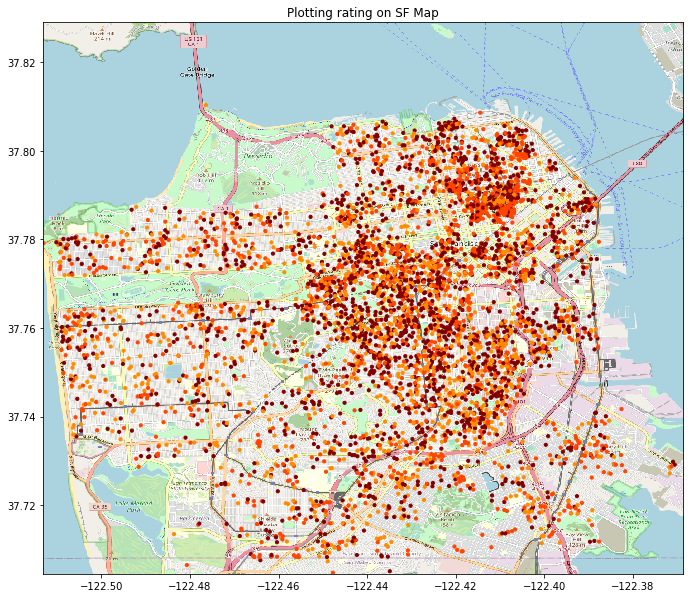

In [44]:
# Visualisation des donnees sur une carte :


#Box = (data.longitude.min(),   data.longitude.max(),      
#        data.latitude.min(), data.latitude.max())
    
Box = (-122.5132, -122.3686,      
       37.7045, 37.8290)

carte = plt.imread("../data/map.png")

fig, ax = plt.subplots(figsize = (11.48,12.48))
ax.scatter(data_to_print.longitude, data_to_print.latitude, zorder=1, alpha= 1, c=color, s=10)
ax.set_title('Plotting rating on SF Map')
ax.set_xlim(Box[0],Box[1])
ax.set_ylim(Box[2],Box[3])
ax.imshow(carte, zorder=0, extent = Box, aspect= 'equal')

#fig.savefig('testeo')

# Export de la base de données

In [101]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, [meta['y']] + meta['quant'] + meta['date']),
        #('cat', categorical_transformer, meta['cat'] + meta['bool'] + ['crime'])
        ('cat', categorical_transformer, meta['cat'] + meta['bool'] + ['crime'] + var_text)
    ])

label = [meta['y']] + meta['quant'] + meta['date'] + meta['cat'] + meta['bool'] + ['crime'] + var_text

In [102]:
X_train = X_train.join(y_train)
df1 = pd.DataFrame(preprocessor.fit_transform(X_train), columns = label)

,review_scores_rating,accommodates,guests_included,availability_365,number_of_reviews_ltm,minimum_nights_avg_ntm,maximum_nights_avg_ntm,bathrooms,bedrooms,beds,host_listings_count,price,extra_people,security_deposit,cleaning_fee,host_response_rate,amenities,host_verifications,maximum_nights,minimum_nights,first_review,last_review,host_since,city,host_response_time,property_type,room_type,bed_type,cancellation_policy,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,host_is_superhost,host_has_profile_pic,host_identity_verified,host_is_close,crime,housing_description,context_description,transit
0,excellent,8,1,76,6,1,60,3,3,3,3,1300,0,0,100,93,53,3,60,1,161,16,376,1,2,3,0,4,1,1,0,0,0,1,1,0,1,2,276,3659,741
1,excellent,1,1,4,4,1,180,1.5,1,1,3,81,0,200,100,100,31,3,180,1,154,84,2621,1,3,4,2,4,3,1,1,0,0,1,1,0,1,0,3123,2269,628
2,good,2,1,347,0,30,1125,1,1,1,1,100,0,0,100,100,6,6,1125,30,2130,1686,2131,1,3,0,2,4,1,1,0,0,0,0,1,1,1,2,3557,379,90
3,bad,2,1,69,0,2,30,1,1,1,2,110,0,100,30,100,18,8,30,2,737,721,3609,1,1,4,2,4,3,1,0,0,0,0,1,1,0,2,2891,1328,593
4,bad,2,2,271,13,2,365,1,1,1,192,184,5,400,40,93,19,4,1125,2,191,19,366,1,3,3,2,4,3,1,1,0,0,0,1,0,1,2,4104,1528,0
5,good,2,2,19,37,2,30,1,1,1,2,126,0,0,50,100,42,6,30,2,1934,16,3412,1,3,0,2,4,1,1,0,0,0,1,1,1,1,2,2854,2681,3188
6,bad,2,1,35,28,3,1125,1,1,1,1,150,0,0,30,100,25,6,1125,3,277,5,1988,1,3,1,2,4,3,1,0,0,0,0,1,1,1,2,658,3296,2302
7,excellent,2,1,295,13,2,7,1,1,1,3,125,0,500,60,100,19,4,7,2,156,17,2940,1,3,4,2,4,3,1,1,0,0,1,1,1,1,2,699,1420,1252
8,excellent,1,1,116,2,30,120,1,1,1,2,65,0,300,130,100,16,2,120,30,242,47,434,1,3,0,2,4,0,1,1,0,0,1,1,0,1,2,3348,3281,2113
9,bad,4,4,93,42,2,28,1,2,4,1,185,10,200,75,91,33,8,28,2,1323,4,2355,1,2,0,0,4,1,1,1,0,0,0,1,1,1,2,2777,1049,2836


In [104]:
X_valid = X_valid.join(y_valid)
df2 = pd.DataFrame(preprocessor.transform(X_train), columns = label)

In [107]:
df1.to_csv ('../data/clean_train.csv',index=False, header=True)
df2.to_csv ('../data/clean_test.csv',index=False, header=True)